In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

stops = set(stopwords.words("english"))

D:\soft\dev\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# nltk.download()

In [2]:
train = pd.read_csv('./data/train.csv')#[:100000] #remove limit
test = pd.read_csv('./data/test.csv')#[:100000] #remove limit

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def get_weight(count, eps=500, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)
words = (" ".join(train_qs)).lower().split() + (" ".join(test_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

def get_unigrams(que):
    return [word for word in nltk.word_tokenize(que.lower()) if word not in stops]

def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

def get_common_unigram_ratio(row):
    return float(row["zunigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

def get_bigrams(que):
    return [i for i in nltk.ngrams(que, 2)]

def get_common_bigrams(row):
    return len( set(row["bigrams_ques1"]).intersection(set(row["bigrams_ques2"])) )

def get_common_bigram_ratio(row):
    return float(row["zbigrams_common_count"]) / max(len( set(row["bigrams_ques1"]).union(set(row["bigrams_ques2"])) ),1)

def get_features(train):
    train['question1_nouns'] = train.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    train['question2_nouns'] = train.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])

    train['z_len1'] = train.question1.map(lambda x: len(str(x)))
    train['z_len2'] = train.question2.map(lambda x: len(str(x)))
    train['z_word_len1'] = train.question1.map(lambda x: len(str(x).split()))
    train['z_word_len2'] = train.question2.map(lambda x: len(str(x).split()))
    #train['z_noun_match'] = train.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long

    #train['z_match_ratio'] = train.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long

    train['z_word_match'] = train.apply(word_match_share, axis=1, raw=True)
    train['z_tfidf_word_match'] = train.apply(tfidf_word_match_share, axis=1, raw=True)

    train["unigrams_ques1"] = train['question1'].apply(lambda x: get_unigrams(str(x)))
    train["unigrams_ques2"] = train['question2'].apply(lambda x: get_unigrams(str(x)))
    train["zunigrams_common_count"] = train.apply(lambda r: get_common_unigrams(r),axis=1)
    train["zunigrams_common_ratio"] = train.apply(lambda r: get_common_unigram_ratio(r), axis=1)
    train["bigrams_ques1"] = train["unigrams_ques1"].apply(lambda x: get_bigrams(x))
    train["bigrams_ques2"] = train["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
    train["zbigrams_common_count"] = train.apply(lambda r: get_common_bigrams(r),axis=1)
    train["zbigrams_common_ratio"] = train.apply(lambda r: get_common_bigram_ratio(r), axis=1)
    return train

In [3]:
train = get_features(train)
train = train.fillna(-1)
# train.to_csv('feat_train.csv', index=False)

D:\soft\dev\anaconda3\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars


In [4]:
col = [c for c in train.columns if c[:1]=='z']

pos_train = train[train['is_duplicate'] == 1]
neg_train = train[train['is_duplicate'] == 0]
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train = pd.concat([pos_train, neg_train])

x_train, x_valid, y_train, y_valid = train_test_split(train[col], train['is_duplicate'], test_size=0.2, random_state=0)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["silent"] = 1
params["seed"] = 1632

In [5]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to 5000
print(log_loss(train.is_duplicate, bst.predict(xgb.DMatrix(train[col]))))
train = [] #clean up
d_train = [] #clean up
d_valid = [] #clean up
watchlist = [] #clean up

[0]	train-logloss:0.683086	valid-logloss:0.683126
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.385365	valid-logloss:0.386857
[200]	train-logloss:0.358203	valid-logloss:0.360088
[300]	train-logloss:0.35337	valid-logloss:0.355473
[400]	train-logloss:0.351162	valid-logloss:0.353418
[500]	train-logloss:0.34927	valid-logloss:0.35172
[600]	train-logloss:0.347745	valid-logloss:0.350371
[700]	train-logloss:0.346557	valid-logloss:0.349353
[800]	train-logloss:0.345504	valid-logloss:0.348462
[900]	train-logloss:0.34469	valid-logloss:0.347779
[1000]	train-logloss:0.343962	valid-logloss:0.347187
[1100]	train-logloss:0.343275	valid-logloss:0.346667
[1200]	train-logloss:0.342644	valid-logloss:0.346193
[1300]	train-logloss:0.342025	valid-logloss:0.345722
[1400]	train-logloss:0.34153	valid-logloss:0.345373
[1500]	train-logloss:0.340985	valid-logloss:0.344962
[1600]	train-loglo

In [6]:
test = get_features(test)
test = test.fillna(-1)
#test.to_csv('test.csv', index=False)

D:\soft\dev\anaconda3\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
d_test = xgb.DMatrix(test[col])
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = p_test

#df['is_duplicate'] = df['is_duplicate'].map(lambda x: 0.000000000001 if x < 0.0001 else x)
#df['is_duplicate'] = df['is_duplicate'].map(lambda x: 0.999999999999 if x > 0.98 else x)

sub.to_csv('z05_submission_xgb_03.csv', index=False)

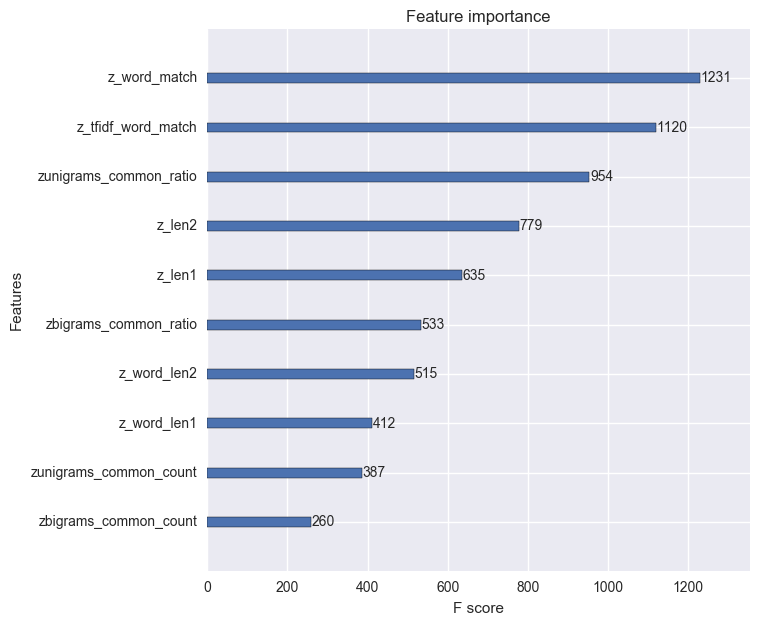

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(bst); plt.show()

ImportError: You must install graphviz to plot tree

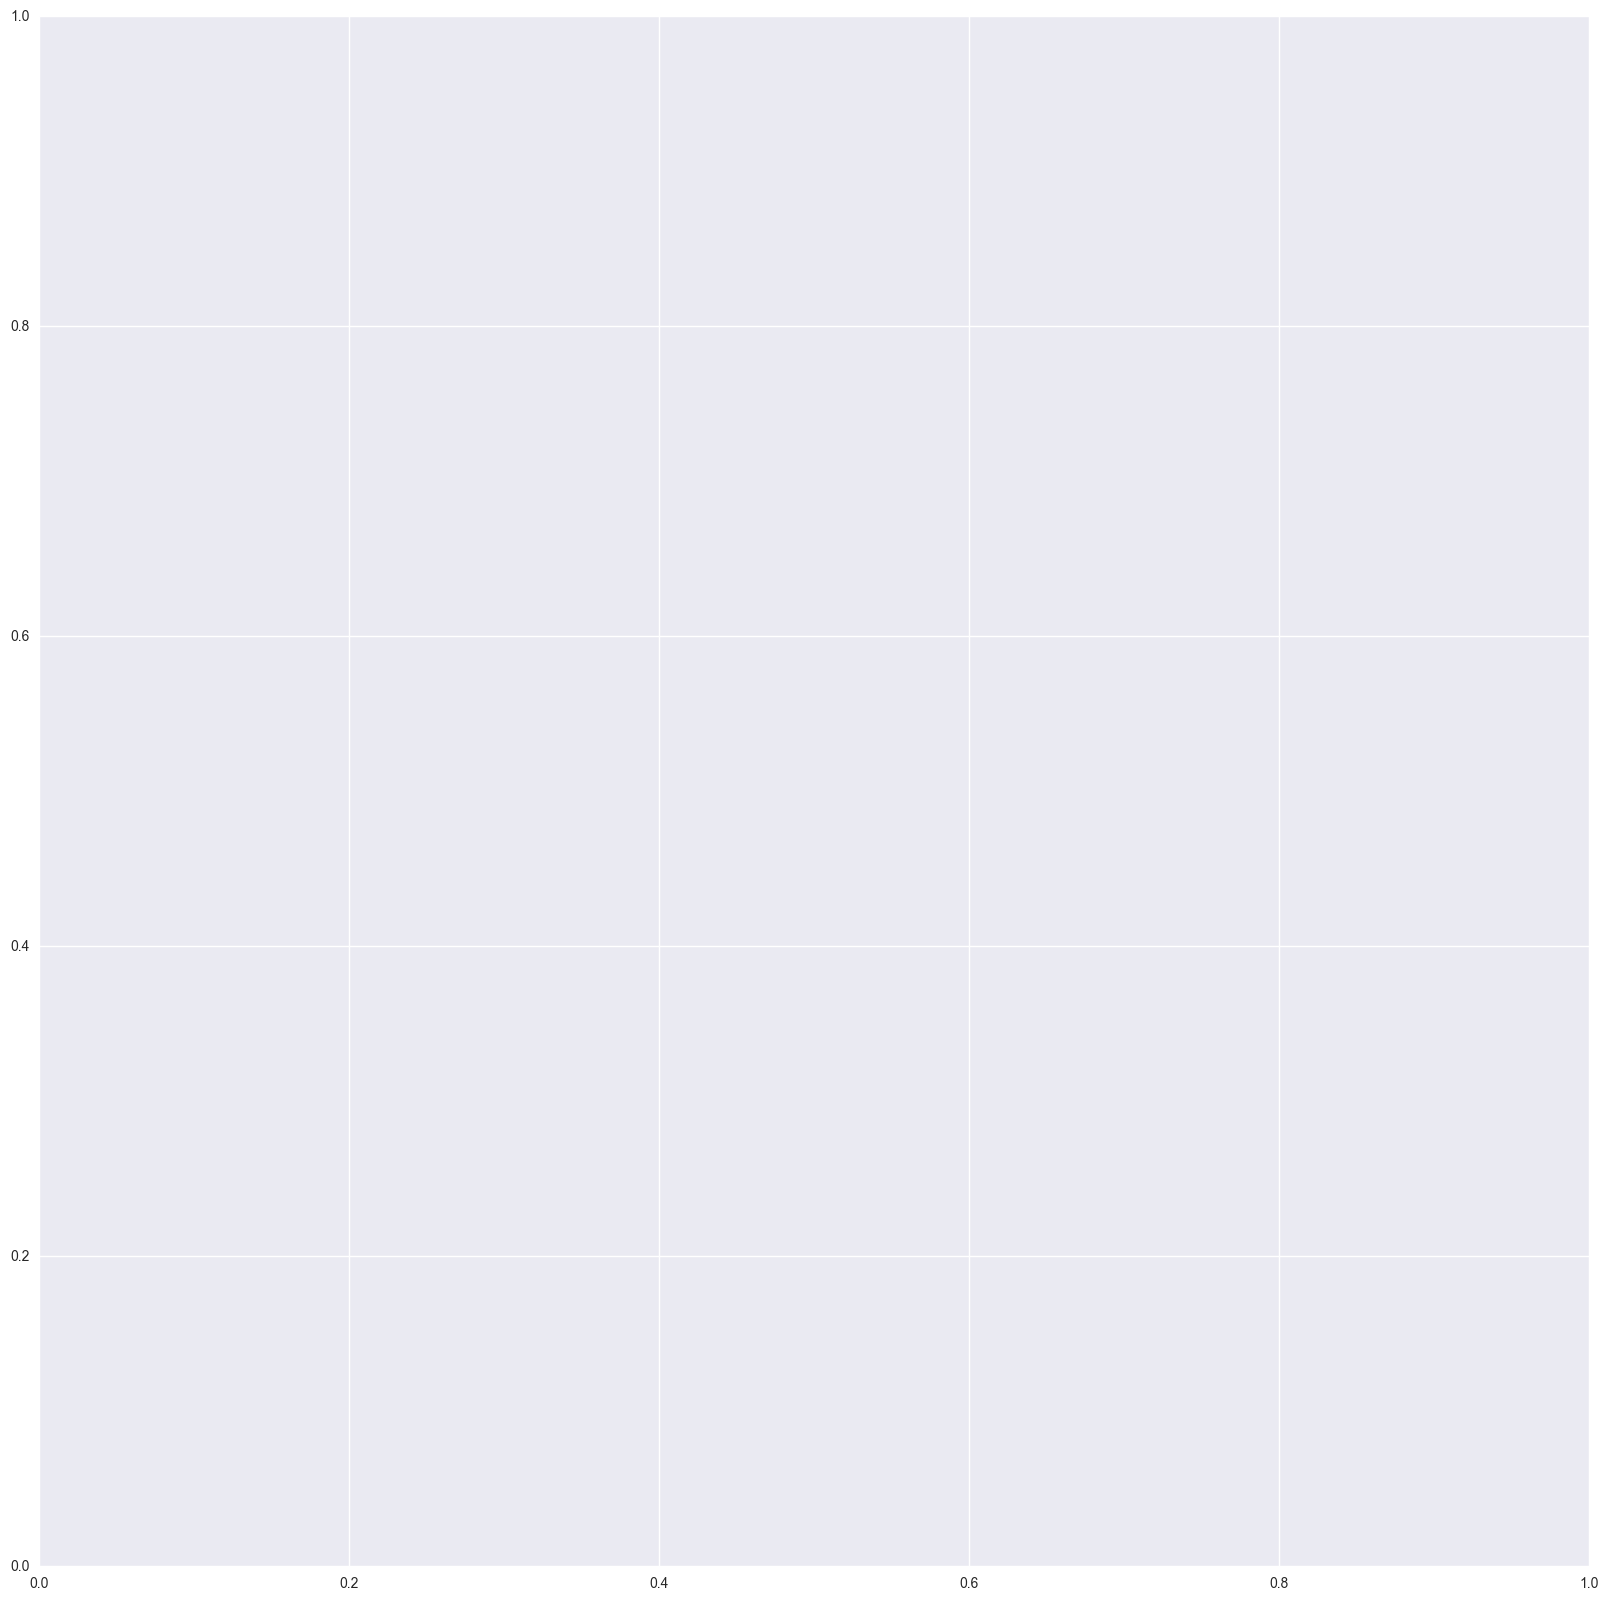

In [10]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
xgb.plot_tree(bst, num_trees=0); plt.show()